
# Basic analysis

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassifi

Top 10 words for topic #0_[ 0.20000216  1.19999444 12.39751199 ...  2.18776078  1.19998637
  1.19937987]:
['great', 'time', 'case', 'professional', 'team', 'thank', 'process', 'highly', 'service', 'recommend']


Top 10 words for topic #1_[0.20000533 0.20000138 3.50091105 ... 0.20000181 0.20000347 0.2000034 ]:
['recommend', 'help', 'professional', 'time', 'solicitors', 'process', 'case', 'team', 'visa', 'thank']


Top 10 words for topic #2_[0.20000455 0.20000116 0.20360904 ... 0.20000153 0.20000287 0.20000283]:
['service', 'professional', 'advice', 'company', 'best', 'highly', 'legal', 'lawyer', 'recommend', 'case']


Top 10 words for topic #3_[ 1.34275609  0.200001   12.80367276 ...  0.20000127  0.20000245
  2.2006091 ]:
['help', 'really', 'solicitor', 'highly', 'time', 'process', 'case', 'legal', 'professional', 'recommend']


Top 10 words for topic #4_[2.05723187 0.20000201 4.09429516 ... 0.21223461 0.20000484 0.20000481]:
['solicitor', 'didn', 'legal', 'recommend', 'years', 'richard

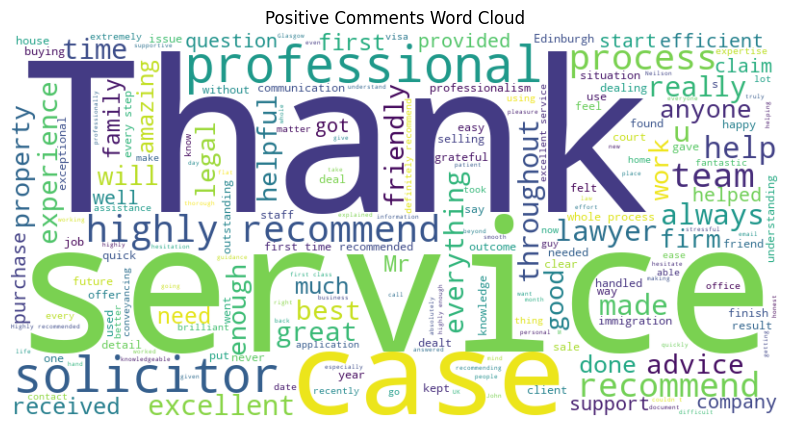

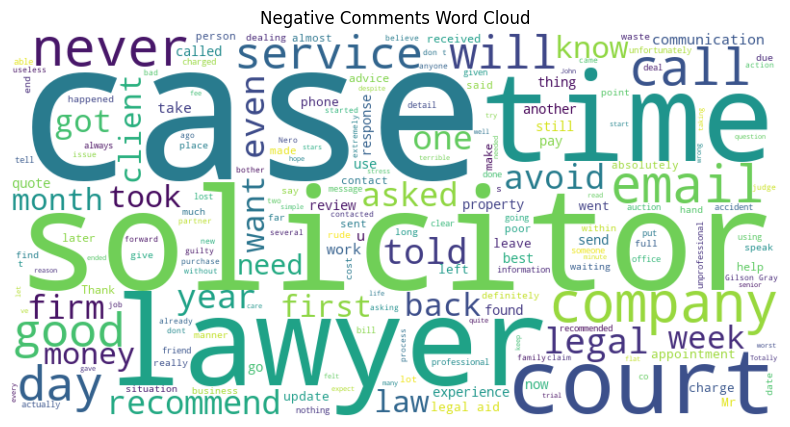

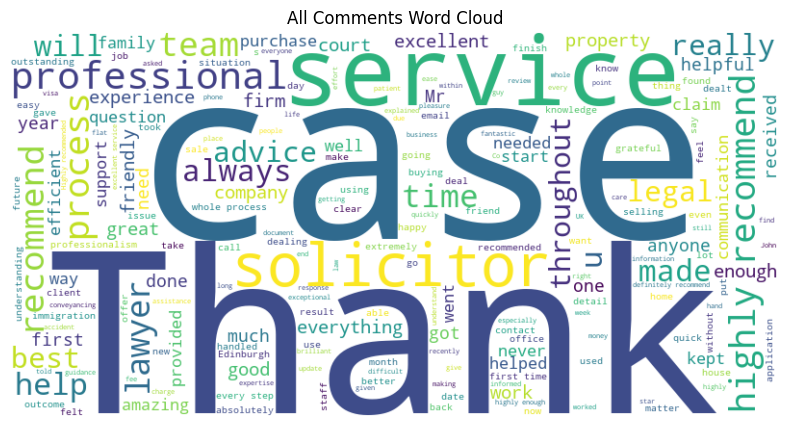

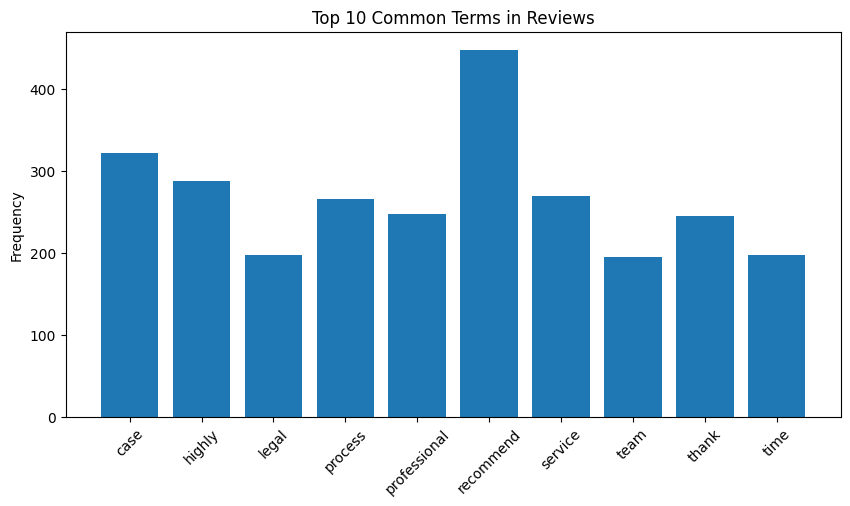

In [50]:
import pandas as pd
from transformers import (
    AutoModelForSequenceClassification,
    AutoConfig,
    AutoTokenizer,
    pipeline,
)
import torch

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from textstat import flesch_reading_ease
from sklearn.decomposition import LatentDirichletAllocation


class LawFirmReviewAnalyzer:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.df = pd.read_csv(dataset_path)

        self.model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

        self.config = AutoConfig.from_pretrained(self.model_name)

        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name, config=self.config
        )
        self.sentiment_pipeline = pipeline("sentiment-analysis", model=self.model_name)

    def sentiment_to_score(self, sentiment_label):
        score_mapping = {"positive": 5, "neutral": 3, "negative": 1}
        return score_mapping.get(sentiment_label.lower(), 0)

    def analyze_sentiments(self):
        def analyze_comment(comment):
            if not isinstance(comment, str):
                comment = str(comment)
            inputs = self.tokenizer(
                comment, return_tensors="pt", truncation=True, max_length=512
            )
            with torch.no_grad(): 
                predictions = self.model(**inputs)
            probs = torch.nn.functional.softmax(predictions.logits, dim=-1)
            labels = [
                "negative",
                "neutral",
                "positive",
            ] 
            label_index = torch.argmax(
                probs, dim=1
            ).item()  
            main_sentiment = labels[label_index]
            return self.sentiment_to_score(main_sentiment)

        self.df["Sentiment Score"] = self.df["comment"].apply(analyze_comment)

    def topic_modeling(self, n_topics=5, n_words=10):
        count_vect = CountVectorizer(stop_words="english")
        doc_term_matrix = count_vect.fit_transform(
            self.df["comment"].fillna("").astype(str)
        )
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
        lda.fit(doc_term_matrix)
        for i, topic in enumerate(lda.components_):
            print(f"Top {n_words} words for topic #{i}_{topic}:")
            print(
                [
                    count_vect.get_feature_names_out()[i]
                    for i in topic.argsort()[-n_words:]
                ]
            )
            print("\n")

    def generate_word_cloud(self, text, title):
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
            text
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()

    def create_word_clouds(self):
        positive_comments = " ".join(
            self.df[self.df["Sentiment Score"] >= 4]["comment"].fillna("").astype(str)
        )
        negative_comments = " ".join(
            self.df[self.df["Sentiment Score"] <= 2]["comment"].fillna("").astype(str)
        )
        all_comments = " ".join(self.df["comment"].fillna("").astype(str))

        self.generate_word_cloud(positive_comments, "Positive Comments Word Cloud")
        self.generate_word_cloud(negative_comments, "Negative Comments Word Cloud")
        self.generate_word_cloud(all_comments, "All Comments Word Cloud")

    def common_terms_analysis(self):
        clean_comments = self.df["comment"].fillna("").astype(str)
        vectorizer = CountVectorizer(stop_words="english", max_features=10)
        counts = vectorizer.fit_transform(clean_comments).toarray().sum(axis=0)
        terms = vectorizer.get_feature_names_out()
        common_terms = dict(zip(terms, counts))

        plt.figure(figsize=(10, 5))
        plt.bar(common_terms.keys(), common_terms.values())
        plt.title("Top 10 Common Terms in Reviews")
        plt.xticks(rotation=45)
        plt.ylabel("Frequency")
        plt.show()

    def save_enriched_dataset(self, output_path):
        self.df.to_csv(output_path, index=False)


dataset_path = "data.csv"
analyzer = LawFirmReviewAnalyzer(dataset_path)
analyzer.analyze_sentiments()
analyzer.topic_modeling()
analyzer.create_word_clouds()
analyzer.common_terms_analysis()
analyzer.save_enriched_dataset("analysed_data_1.csv")

<Axes: xlabel='Sentiment Score'>

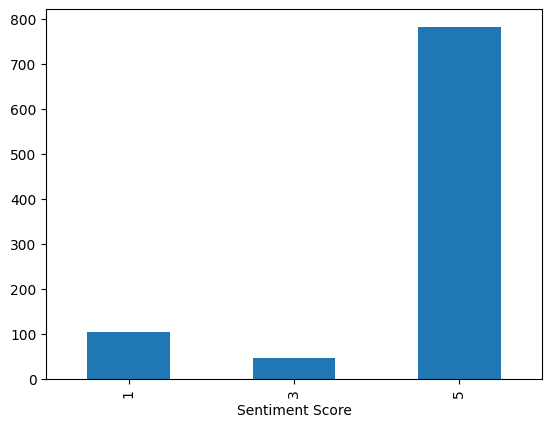

In [48]:
data = pd.read_csv("analysed_data_1.csv")
data["Sentiment Score"].value_counts().sort_index().plot(kind="bar")